In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

In [3]:
cat_cols =[
    'market_segment',
    'distribution_channel',
    'deposit_paid',
    'got_requested_room_type',
    'customer_type',
    'country_grouped'
    ]

num_cols =[
    'lead_time',
    'required_car_parking_spaces',
    'special_requests_clipped',
    ]

In [4]:
df_resort=pd.read_pickle("cleaned_resort_bookings.pkl")
y = df_resort['is_canceled']
X = df_resort[cat_cols+num_cols]

In [5]:
print(df_resort.dtypes)
for col in cat_cols:
    df_resort[col] = df_resort[col].astype('category')

hotel                                   category
is_canceled                                int64
lead_time                                  int64
arrival_date_year                          int64
arrival_date_month                        object
arrival_date_week_number                   int64
arrival_date_day_of_month                  int64
stays_in_weekend_nights                    int64
stays_in_week_nights                       int64
adults                                     int64
children                                 float64
babies                                     int64
meal                                    category
country                                   object
market_segment                            object
distribution_channel                      object
is_repeated_guest                          int64
previous_cancellations                     int64
previous_bookings_not_canceled             int64
reserved_room_type                        object
assigned_room_type  

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough'
)
pipeline = Pipeline(steps=[
    ('prep', preprocessor),
    ('model', LGBMClassifier(random_state=42))
])


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
    )
pipeline.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 8874, number of negative: 22946
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 308
[LightGBM] [Info] Number of data points in the train set: 31820, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.278881 -> initscore=-0.950018
[LightGBM] [Info] Start training from score -0.950018


,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [8]:
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.4f}")


AUC: 0.9307


c:\Users\kevin\Hotel_Bookings\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


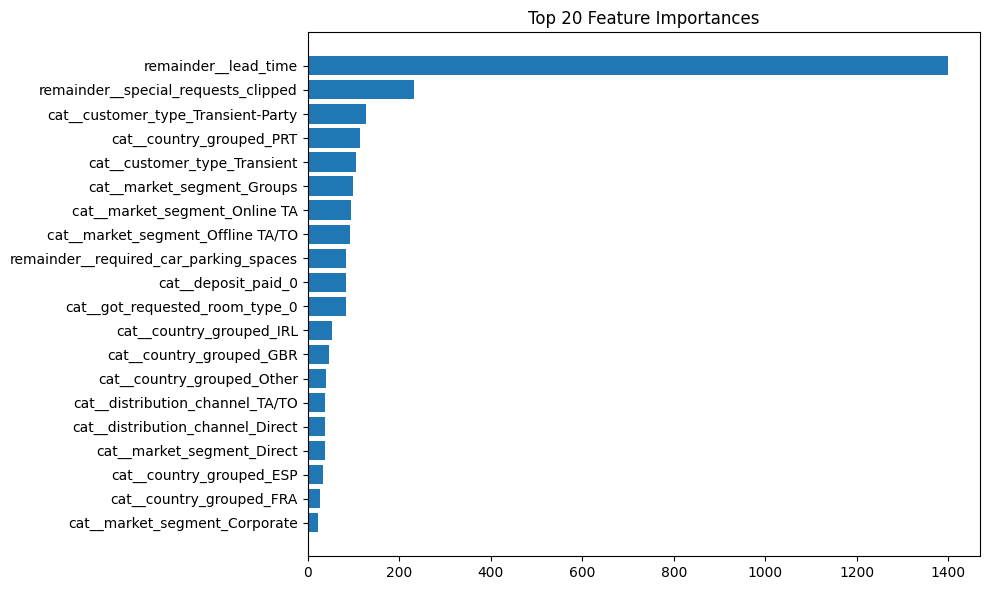

In [9]:
import matplotlib.pyplot as plt
# Namen der Features nach OneHotEncoding
feature_names = pipeline.named_steps['prep'].get_feature_names_out()
# Importances holen
importances = pipeline.named_steps['model'].feature_importances_
# DataFrame erstellen
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plotten
plt.figure(figsize=(10,6))
plt.barh(feat_imp['Feature'][:20][::-1], feat_imp['Importance'][:20][::-1])
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()